# IM (Ianniruberto, G.and Marrucci, G.) Differential Model, or DCR-CS Model
ref: Ianniruberto, G.; Marrucci, G. A simple constitutive equation for entangled polymers with chain stretch. *Journal of Rheology* __2001__, 45, 1305-1318.  
Define an effective time $\tau_{eff}$ to replace the disengagement time $\tau_d$ in DE model:  
The classical DE model of $\mathbf{S}(t)$ is replaced to be:  

$$\begin{align}
&\overset{\bigtriangledown }{\mathbf{S}^2} +2\mathbf{S}^2(\boldsymbol{\kappa}:\mathbf{S})+\frac{2}{\tau}\mathbf{S}\cdot\left(\mathbf{S}-\frac{1}{3}\mathbf{I}\right) = \mathbf{0}\\
&\tau = \frac{1}{2\left(\frac{1}{\tau_d}+\boldsymbol{\kappa}:\mathbf{S}\right)} + \tau_R\\
&\frac{d\lambda}{dt} = \lambda\boldsymbol{\kappa}:\mathbf{S} - \frac{\lambda F(\lambda)-1}{\tau_R} \\
&F(\lambda) = \left(\frac{\lambda_{max}^2-\frac{\lambda^2}{3}}{\lambda_{max}^2-\lambda^2}\right)\left(\frac{\lambda_{max}^2-1}{\lambda_{max}^2-\frac{1}{3}}\right) \\
&\boldsymbol{\sigma} = 3G_N^0 F(\lambda)\lambda^2\boldsymbol{S}
\end{align}$$  

Here:  
$$
\overset{\bigtriangledown }{\mathbf{S}^2} = \mathbf{S}\cdot \dot{\mathbf{S}} + \dot{\mathbf{S}}\cdot \mathbf{S} -\boldsymbol{\kappa}\cdot\mathbf{S}^2-\mathbf{S}^2\cdot\boldsymbol{\kappa}^T
$$

In [5]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pylab

In [61]:
#parameters for PS133k in ref: Costanzo, S. et al. Macromolecules 2016, 49, 3925-3935.
GN0 = 2.79E5
τc = 1.24E-3
τR = 0.124
λmax = 3.34
Gi = np.array([1.14E2, 2.52, 8.80E-1, 3.81E-1, 2.07E-1, 1.70E-1, 1.76E-1, 1.37E-1, 2.03E-1]) * GN0
τi_eq = np.array([2.16E-3, 5.90E-2, 3.33E-1, 1.53, 6.87, 2.9E1, 1.11E2, 3.63E2, 8.92E2]) * τc
τd_eq = np.sum(Gi*τi_eq**2)/np.sum(Gi*τi_eq)

In [62]:
shear_rate = 31.6 # 1/s
κ = np.array([[0,shear_rate,0],\
              [0,0,0],\
              [0,0,0]])
δt = 0.001 # seconds
finish_time = 100 # senconds
t_span = np.arange(0,finish_time,δt)

In [76]:
S_span = np.zeros([len(t_span),3,3]) # orientation tensor S
S2_span = np.zeros([len(t_span),3,3]) # orientation tensor S**2
τd_span = np.zeros(len(t_span)) # tau_d
λ_span = np.zeros(len(t_span)) # λ
σ_span = np.zeros([len(t_span),3,3]) # σ stress
for ind,t in enumerate(t_span):
    # initial the value at time = 0s 
    if ind == 0:
        S_span[0,:,:] = np.eye(3)/3
        S2_span[0,:,:] = np.eye(3)/9
        τd_span[0] = τd_eq/2 + τR
        λ_span[0] = 1
        σ_span[0,:,:] = 3 * GN0 * np.eye(3)/3
        continue
    # calculate the τd(t)
    S_t = S_span[ind-1,:,:] #S at time t
    S2_t = S2_span[ind-1,:,:] #S2 at time t
    τd_t = 1/2/(1/τd_eq + np.trace(np.dot(κ,S_t))) + τR
    τd_span[ind] = τd_t
    
    # dS2_dt at time t update
    dS2_dt = np.dot(κ, S2_t) + np.dot(S2_t, κ.T) - \
            2 * S2_t * np.trace(np.dot(κ, S_t)) - \
            2/τd_t * np.dot(S_t, S_t-np.eye(3)/3)
    S2_update = S2_t + dS2_dt * δt
    S2_span[ind,:,:] = S2_update
    eigs, eig_vec = np.linalg.eig(S2_update)
    S_update = np.dot(eig_vec,np.dot(np.diag(np.sqrt(eigs)),eig_vec.T))
    S_span[ind,:,:] = S_update
    
    # calculate the dλ_dt
    λ = λ_span[ind-1]
    Fλ = (λmax**2 - λ**2/3)/(λmax**2 - λ**2)*(λmax**2 - 1)/(λmax**2 - 1/3)
    dλ_dt = λ * np.trace(np.dot(κ,S_update)) - (λ * Fλ - 1) / τR
    λ_update = λ + dλ_dt * δt
    λ_span[ind] = λ_update
    Fλ_update = (λmax**2 - λ_update**2/3)/(λmax**2 - λ_update**2) * (λmax**2 - 1)/(λmax**2 - 1/3)
    σ_update = 3 * GN0 * Fλ_update * λ_update**2 * S_update
    σ_span[ind] = σ_update
    if ind == 2000:
        break

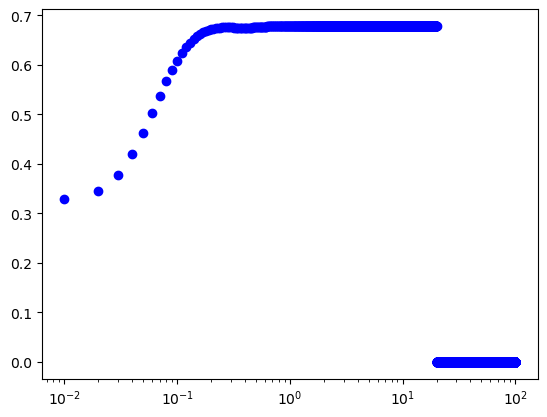

In [79]:
pylab.semilogx(t_span,S_span[:,0,0],'bo')

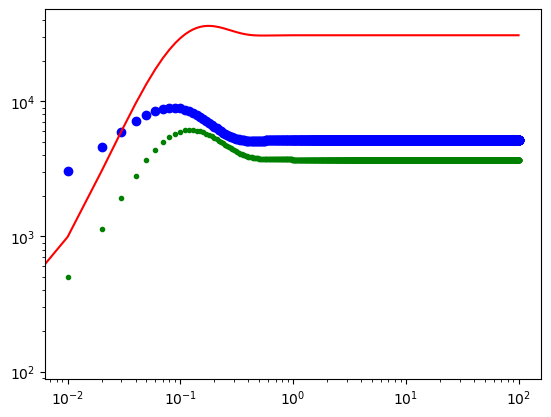

In [67]:
pylab.loglog(t_span-δt,σ_span[:,0,1]/shear_rate,'bo')
pylab.loglog(t_span-δt,(σ_span[:,0,0]-σ_span[:,1,1])/shear_rate,'r-')
pylab.loglog(t_span-δt,(σ_span[:,2,2]-σ_span[:,1,1])/shear_rate,'g.')

In [74]:
τd_eq, τd_span[-1],λ_span[-1]

(0.8743363392883154, 0.24746899912428208, 1.4038785780315999)

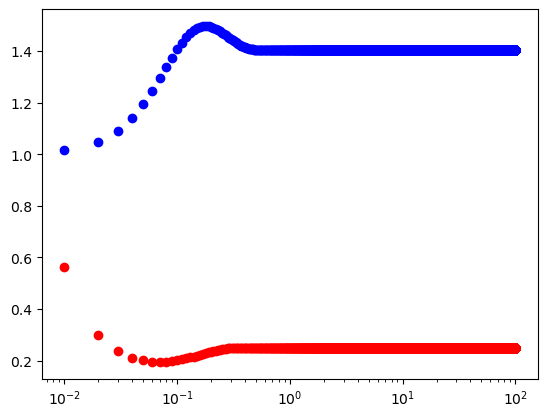

In [70]:
pylab.semilogx(t_span,τd_span,'ro')
pylab.semilogx(t_span,λ_span,'bo')